# Twitter Sentiment Analysis: Classifying Hate Speech

The goal for this project is to build a model that will allow us to detect hate speech in tweets. In this case a tweet is considered to be hate speech if it contains racist or sexist remarks.

All data for this project is sourced from: https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/. Inspiration and some code for this project has been taken from:
- 'Stemming - Natural Language Processing With Python and NLTK p.3'- https://www.youtube.com/watch?v=yGKTphqxR9Q
- https://datascienceplus.com/twitter-analysis-with-python/
- Ultimate guide to deal with Text Data (using Python) – for Data Scientists & Engineers - https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- 'Deep Learning tutorials in jupyter notebooks.' - https://github.com/sachinruk/deepschool.io


## Exploring the data & summarizing some basic features

To begin we read our training data into a dataframe and briefly explore the data set

In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./train_E6oV3lV.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [2]:
df.shape

(31962, 3)

This is labelled training data. Each row is 3-tuple (id, label, tweet). A label of 1 means the tweet is hate speech, a label of 0 is a normal tweet.

In [3]:
df.tail()

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


How many tweets are labelled as "Hate Speech" in our training data set?

In [4]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

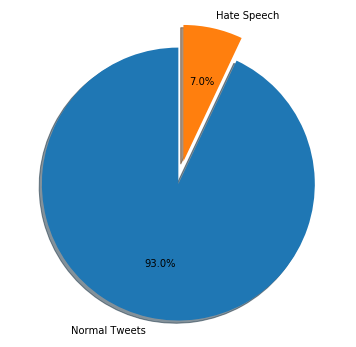

In [5]:
labels = ['Normal Tweets', 'Hate Speech']
colors = ['b', 'r']
sizes = df.label.value_counts()
explode = (0, 0.17)

fig1, ax1 = plt.subplots()
fig1.set_size_inches((6, 6))
ax1.pie(sizes, shadow=True, explode=explode, labels=labels, startangle=90, autopct='%.1f%%', )
plt.axis("equal")
plt.show()

We would like to be able to apply this binary classification to our test data set. We will ultimately measure the success of our model using the **F1 Score** described below:

**True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

**True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

**False Positives (FP)** – When actual class is no and predicted class is yes.

**False Negatives (FN)** – When actual class is yes but predicted class in no.

**Precision** = TP/TP+FP

**Recall** = TP/TP+FN

**F1 Score** = 2*(Recall * Precision) / (Recall + Precision)

https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/

Next we will summarize some features of the data such as the number of words, number of characters and average word length for each tweet. These may prove useful as features in our model, for example shorter tweets may be more likely to contain hate speech.

In [6]:
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split(" ")))
print('Mean word count', df.word_count.mean())
df[['tweet','word_count']].head()

Mean word count 16.048182216381953


,tweet,word_count
0,@user when a father is dysfunctional and is s...,21
1,@user @user thanks for #lyft credit i can't us...,22
2,bihday your majesty,5
3,#model i love u take with u all the time in ...,17
4,factsguide: society now #motivation,8


In [7]:
df['char_count'] = df['tweet'].str.len() # includes spaces
print('Mean character count', df.char_count.mean())
df[['tweet','char_count']].head()

Mean character count 84.73962830861649


,tweet,char_count
0,@user when a father is dysfunctional and is s...,102
1,@user @user thanks for #lyft credit i can't us...,122
2,bihday your majesty,21
3,#model i love u take with u all the time in ...,86
4,factsguide: society now #motivation,39


## Cleaning and Preparing the Data 

The first step we will take to prepare our data for building a model is to transform all tweet text to be lower case. This is an important step since we will be counting the frequencies of words later.

In [8]:
df.tweet = df.tweet.apply(lambda x: " ".join(x.lower() for x in x.split()))
df.tweet.head()

0    @user when a father is dysfunctional and is so...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model i love u take with u all the time in ur...
4                  factsguide: society now #motivation
Name: tweet, dtype: object

We will also remove punctuation since it does not provide any valuable information.

In [9]:
df.tweet = df.tweet.str.replace('[^\w\s]','')
df.tweet.head()

0    user when a father is dysfunctional and is so ...
1    user user thanks for lyft credit i cant use ca...
2                                  bihday your majesty
3    model i love u take with u all the time in urð...
4                    factsguide society now motivation
Name: tweet, dtype: object

The first feature we wish to extract for building our model is to count the frequencies of every word as they occur in each tweet. This is known as the 'bag-of-words' method in in Natural Language rocessing (NLP). We can think of the bag-of-words as representing each tweet as a multiset, or alternatively a vector. The `sklearn.feature_extraction.text` submodule provides an easy means of vectorizing our tweets. http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage


In [10]:
# convert collection of tweets to a matrix of frequency counts for each word
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(df.tweet.values)
tf_backup = tf

print(type(tf))
tf.shape

<class 'scipy.sparse.csr.csr_matrix'>


(31962, 45131)

In [11]:
print('Number of unique words: ',len(tf_vectorizer.get_feature_names()))
print('First 10 word labels: ', tf_vectorizer.get_feature_names()[:10])

Number of unique words:  45131
First 10 word labels:  ['0000001', '00027', '001', '0035', '00h30', '01', '0115', '0161', '019', '01926889917']


Looking at the first 10 words in our 'bag' we can see that there is a lot of noise in the data. In order to extract useful features we would like to filter these from our data (known as stop words in NLP). We use the sklearn CountVectorizer() to filter out common English language words ('the', 'a', 'to', etc.) and any word appearing less than 5 times in the data.

In [12]:
tf_vectorizer = CountVectorizer(min_df=5,stop_words='english')
tf = tf_vectorizer.fit_transform(df.tweet.values)
print('New number of unique words: ',len(tf_vectorizer.get_feature_names()))
print(type(tf))
tf.shape

New number of unique words:  5975
<class 'scipy.sparse.csr.csr_matrix'>


(31962, 5975)

We have reduced the number of words in our vocabulary dictionary (the words we are counting the frequencies of for each tweet) from 45131 to 5975. Cleaning these meaningless words from the data will hopefully improve the accuracy of our model. Lets see if this extra step combined with the basic cleaning & preprocessing we have already done is will let us extract some useful features for our model.

In [13]:
# shuffle the data then split into two halves to cross-validate
idx = np.random.permutation(len(df))
X_train = tf[idx][:15981].todense()
X_test = tf[idx][15981:].todense()
print(type(tf))
y_train = df.label.values[idx][:15981]
y_test = df.label.values[idx][15981:]

<class 'scipy.sparse.csr.csr_matrix'>


In [14]:
X_train.shape

(15981, 5975)

We will use the Keras neural network API for training the model with TensorFlow backend

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1

Using TensorFlow backend.


In [16]:
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=tf.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               597600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 597,701
Trainable params: 597,701
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train, y_train, epochs=2, batch_size=128)

Epoch 1/2
15981/15981 [==============================] - 2s 113us/step - loss: 0.2078 - binary_accuracy: 0.9365
Epoch 2/2
15981/15981 [==============================] - 2s 100us/step - loss: 0.1094 - binary_accuracy: 0.9608


Keras gives us two functions for making predictions with our model. `model.predict(...)` predicts the probability of a tweet belong to a particular class. `model.predict_class(...)` which gives 1 or 0.

In [18]:
# compute predictions for one half of our training data
y_test_pred = model.predict(X_test)

In [19]:
print(y_test_pred.shape)
y_test_pred

(15981, 1)


array([[0.04774841],
       [0.01340003],
       [0.18528488],
       ...,
       [0.0717034 ],
       [0.01027054],
       [0.0706132 ]], dtype=float32)

In [20]:
# Convert to 0/1 labels and count how many Normal tweets
y_test_pred[y_test_pred<0.5] = 0
y_test_pred[y_test_pred>=0.5] = 1
np.count_nonzero(y_test_pred==y_test[:,None])*1.0/len(y_test)

0.9536324385207434

Recall that our original distribution for the test data was 93% normal and 7% hate speech. So this is a plausible distribution at least. Lets try a few manual test cases.

In [21]:
test_case = tf_vectorizer.transform(["trump will build a wall"])
model.predict(test_case.todense())

array([[0.72286355]], dtype=float32)

In [22]:
test_case = tf_vectorizer.transform(["trump trump trump trump"])
model.predict(test_case.todense())

array([[0.95061004]], dtype=float32)

In [23]:
test_case = tf_vectorizer.transform(["can't wait to go to the beach this summer"])
model.predict(test_case.todense())

array([[0.01221364]], dtype=float32)

In [24]:
test_case = tf_vectorizer.transform(["I like pies"])
model.predict(test_case.todense())

array([[0.2631941]], dtype=float32)

In [25]:
test_case = tf_vectorizer.transform(["police brutality fuels race tensions"])
model.predict(test_case.todense())

array([[0.6247769]], dtype=float32)

In [26]:
test_case = tf_vectorizer.transform(["police brutally fueling racial tension"])
model.predict(test_case.todense())

array([[0.5071551]], dtype=float32)

These test cases suggest our model has quite limited predictive power. This is hardly surprising given such a naive approach. For example the first & second tweet do not seem to convey any racist sentiment, although it - although it seems to have some success at identifying words that are probably *associated* with racist/sexist tweets.

In the the last test case the hate speech prediction changes by around 12% simply from including different word endings. Lets try a more advanced preprocessing technique known as **lemmatization**.

Lemmatization is a NLP technique similar to stemming. Both seek to reduce inflectional forms by reducing related words to their morphological root. e.g. [carrying, carried] -> carry. Stemming generally simply looks for suffixes to chop off, while lemmatization uses vocabularly and morpholigical analysis. https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

Thus with lemmatization we be able to further reduce the number of words in our 'bag-of-words' vocabulary.

In [27]:
import nltk
from textblob import Word

nltk.download('wordnet')
df.tweet = df.tweet.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.tweet.head()

[nltk_data] Downloading package wordnet to /home/trix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    user when a father is dysfunctional and is so ...
1    user user thanks for lyft credit i cant use ca...
2                                  bihday your majesty
3    model i love u take with u all the time in urð...
4                    factsguide society now motivation
Name: tweet, dtype: object

Lets try retraining our model using the lemmatized data.

In [28]:
tf_vectorizer = CountVectorizer(min_df=5,stop_words='english')
tf = tf_vectorizer.fit_transform(df.tweet.values)
print('New number of unique words: ',len(tf_vectorizer.get_feature_names()))
print(type(tf))
tf.shape

New number of unique words:  5649
<class 'scipy.sparse.csr.csr_matrix'>


(31962, 5649)

Using lemmatization we have decreased the number of words in our 'bag-of-words' from 5975 to 5649

In [40]:
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=tf.shape[1]))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])
model.summary()

# shuffle the data then split into two halves to cross-validate
idx = np.random.permutation(len(df))
X_train = tf[idx][:15981].todense()
X_test = tf[idx][15981:].todense()
print(type(tf))
y_train = df.label.values[idx][:15981]
y_test = df.label.values[idx][15981:]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               565000    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 565,101
Trainable params: 565,101
Non-trainable params: 0
_________________________________________________________________
<class 'scipy.sparse.csr.csr_matrix'>


In [49]:
model.fit(X_train, y_train, epochs=2, batch_size=128)

Epoch 1/2
15981/15981 [==============================] - 2s 97us/step - loss: 0.0801 - binary_accuracy: 0.9721
Epoch 2/2
15981/15981 [==============================] - 2s 97us/step - loss: 0.0654 - binary_accuracy: 0.9792


In [42]:
# compute predictions for one half of our training data
y_test_pred = model.predict(X_test)

In [43]:
# Convert to 0/1 labels and count how many Normal tweets
y_test_pred[y_test_pred<0.5] = 0
y_test_pred[y_test_pred>=0.5] = 1
np.count_nonzero(y_test_pred==y_test[:,None])*1.0/len(y_test)

0.9582003629309805

Lets run the same test cases for comparison.

In [44]:
test_case = tf_vectorizer.transform(["trump will build a wall"])
model.predict(test_case.todense())

array([[0.6499358]], dtype=float32)

In [45]:
test_case = tf_vectorizer.transform(["trump trump trump trump"])
model.predict(test_case.todense())

array([[0.9451615]], dtype=float32)

In [35]:
test_case = tf_vectorizer.transform(["can't wait to go to the beach this summer"])
model.predict(test_case.todense())

array([[0.01054552]], dtype=float32)

In [46]:
test_case = tf_vectorizer.transform(["I like pies"])
model.predict(test_case.todense())

array([[0.24642119]], dtype=float32)

In [51]:
test_case = tf_vectorizer.transform(["police brutality fuels race tensions"])
model.predict(test_case.todense())

array([[0.76599085]], dtype=float32)

In [50]:
test_case = tf_vectorizer.transform(["police brutally fueling racial tension"])
model.predict(test_case.todense())

array([[0.6985331]], dtype=float32)

This time the last 2 test cases using words with the same morpholigcal root had much more similar prediction scores, suggesting that the lemmatization was succesful and possibly helpful for analysing the sentiment as well. (Since these two tweets convey essentially the same sentiment we would expect their scores to be similar).

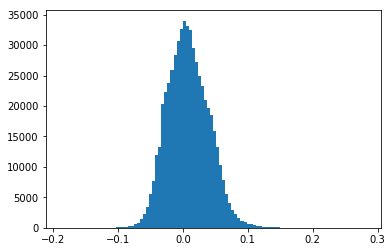

In [39]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

## Conclusion
By experimenting with various cleaning/preprocessing approaches then feeding them into a very basic model for sentiment analysis we can get some idea of whether these steps are helpful for feature extraction in this context. 

In the next stage of this project we will investigate improving our predictions with a more advanced model. We may improve on the 'bag-of-words' approach using Term Frequency - inverse Document Frequency (Tfidf). Or utilise a more sophisticated method such as a Recurrent Neural Network capable of taking into account word order. The preprocessing steps we have already carried out will most likely be useful for these approaches as well.